In [1]:
# 패키지 임포트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
# 데이터 다운로드
data = yf.download('SPY TLT', start='2002-07-30')

# 수정종가를 제외한 나머지 컬럼 삭제
data.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)

# 첫 번째 컬럼 레벨을 삭제
data = data.droplevel(0, axis=1)

# 가격 데이터를 주간 단위로 재설정
data = data.resample('W').last()

[*********************100%***********************]  2 of 2 completed


In [3]:
data

Ticker,SPY,TLT
Date,,
2002-08-04 00:00:00+00:00,57.339169,39.926174
2002-08-11 00:00:00+00:00,60.312122,40.416615
2002-08-18 00:00:00+00:00,61.587223,40.502350
2002-08-25 00:00:00+00:00,62.498955,40.902328
2002-09-01 00:00:00+00:00,60.635834,41.464184
...,...,...
2024-08-18 00:00:00+00:00,554.309998,97.123917
2024-08-25 00:00:00+00:00,562.130005,98.070839
2024-09-01 00:00:00+00:00,563.679993,96.176994


# 1. Semi-Deviation


$$ Dσ = \sqrt{\frac{1}{N-1}Σ_{i=1}^{N}[min(r_{i}, 0)]^{2}} $$


Text(0, 0.5, 'Down Deviation')

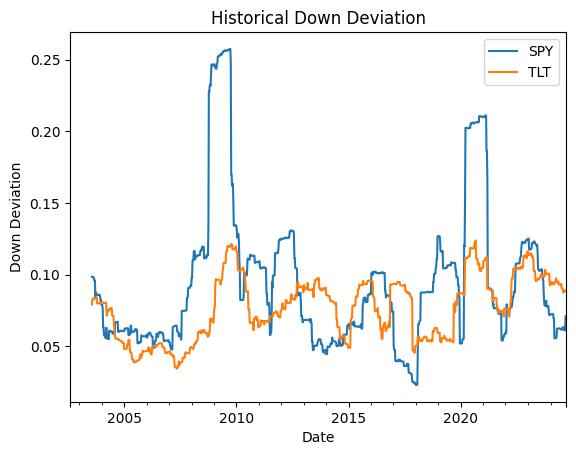

In [4]:
# 각 ETF 가격 데이터 추출
spy_price = data['SPY']
tlt_price = data['TLT']

# 수익률 계산
spy_ret = spy_price.pct_change().fillna(0)
tlt_ret = tlt_price.pct_change().fillna(0)

# 수익률이 플러스인 경우 값을 0으로 변환
spy_ret.loc[spy_ret >= 0] = 0
tlt_ret.loc[tlt_ret >= 0] = 0

# 하방표준편차 계산
spy_down_dev = spy_ret.rolling(52).std() * np.sqrt(52)
tlt_down_dev = tlt_ret.rolling(52).std() * np.sqrt(52)

# 하방표준편차 시각화
spy_down_dev.plot(label='SPY', legend=True)
tlt_down_dev.plot(label='TLT', legend=True)
plt.title('Historical Down Deviation')
plt.xlabel('Date')
plt.ylabel('Down Deviation')


# 2. DD; Drawdown & MDD; Maximum Drawdown



$$ DD_{t} = \frac{P_{t}}{HWM_{t}} - 1 $$



$$ MDD_{t} = min(DD_{t}) $$



In [5]:
# SPY 역사적 전고점 계산
spy_hwm = spy_price.cummax()

# SPY 낙폭 계산
spy_dd = (spy_price / spy_hwm) - 1

Text(0, 0.5, 'Return')

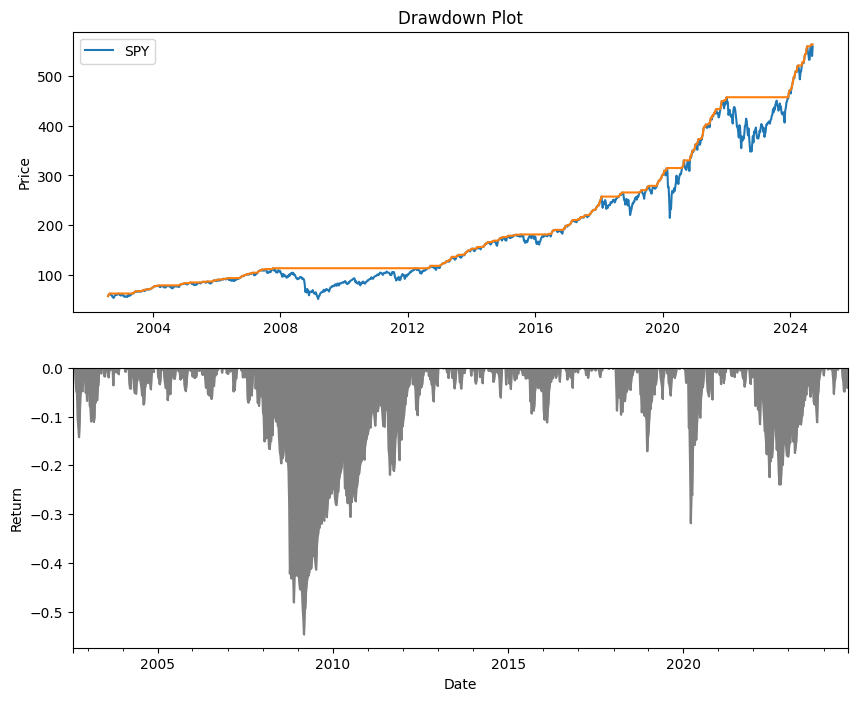

In [6]:
# SPY 낙폭 시각화
fig = plt.figure(figsize=(10, 8))

# 위쪽 그래프 시각화
ax1 = fig.add_subplot(2, 1, 1)
plt.title('Drawdown Plot')
plt.plot(spy_price, label='SPY')
plt.plot(spy_hwm)
plt.legend()
plt.ylabel('Price')

# 아래쪽 그래프 시각화
ax2 = fig.add_subplot(2, 1, 2)
spy_dd.plot.area(color='grey')
plt.xlabel('Date')
plt.ylabel('Return')

In [7]:
spy_dd.min()

-0.5461299878161192

# 3. VaR (Value-at-Risk)

The methods for calculating VaR (Value at Risk) can be broadly categorized into the following: 1) Parametric (Delta-Normal) method, 2) Non-parametric (Historical VaR), 3) Monte Carlo method (Monte Carlo VaR), and 4) Modified VaR (Cornish-Fisher VaR). However, we will focus solely on the Historical VaR, which is based on past return data.

The formula for calculating Historical VaR is as follows: simply arrange the past return data in ascending order and select the value that corresponds to the lower 1% percentile (or whichever confidence level is chosen). This gives you the historical VaR value at the specified confidence level.

Value-at-Risk
$$ VaR_{δ} = Quantile(R, δ) $$



In [8]:
# SPY 수익률 계산
spy_ret = spy_price.pct_change().fillna(0)

# SPY 99% VaR 계산
spy_VaR = spy_ret.quantile(0.01)
print('VaR = {}'.format(spy_VaR))

VaR = -0.06505048999926208


Text(0, 0.5, 'Frequency')

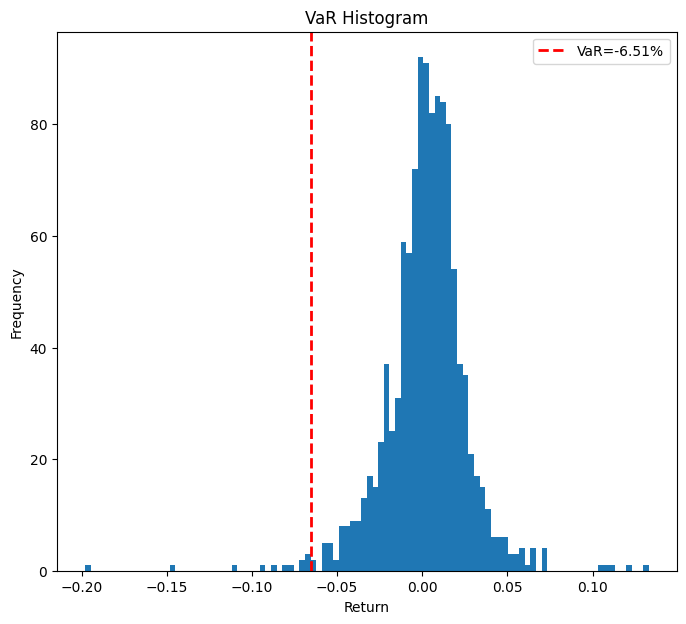

In [9]:
# VaR 히스토그램 시각화
plt.figure(figsize=(8, 7))

# SPY 수익률 히스토그램
plt.hist(spy_ret, bins=100)

# VaR 지점 수직선 표시
plt.axvline(spy_VaR, color='r', linestyle='dashed', linewidth=2, label='VaR={}%'.format(np.round(spy_VaR* 100, 2)))

plt.title('VaR Histogram')
plt.legend()
plt.xlabel('Return')
plt.ylabel('Frequency')


# 4. CVaR (Conditional Value-at-Risk)
Conditional Value-at-Risk
$$ CVaR_{δ} = E(R|R \leq VaR_{δ}) $$



In [10]:
# CVaR 계산
spy_CVaR = spy_ret[spy_ret <= spy_VaR].mean()
print('SPY CVaR = {}'.format(spy_CVaR))

SPY CVaR = -0.09477749897401727


Text(0, 0.5, 'Frequency')

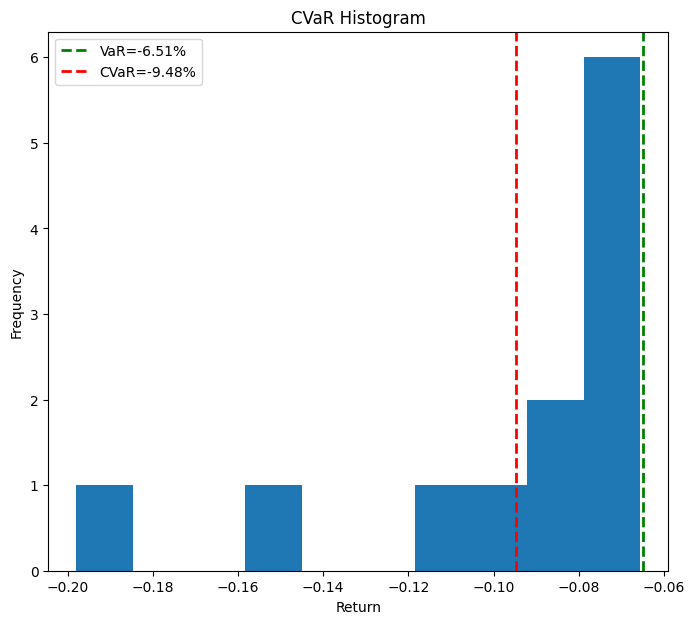

In [11]:
# CVaR 히스토그램 시각화
plt.figure(figsize=(8, 7))

# VaR 값보다 작은 수익률 데이터들의 히스토그램
plt.hist(spy_ret[spy_ret <= spy_VaR])

# VaR 수직선 표시
plt.axvline(spy_VaR, color='g', linestyle='dashed', linewidth=2, label='VaR={}%'.format(np.round(spy_VaR * 100, 2)))

# CVaR 수직선 표시
plt.axvline(spy_CVaR, color='r', linestyle='dashed', linewidth=2, label='CVaR={}%'.format(np.round(spy_CVaR * 100, 2)))

plt.title('CVaR Histogram')
plt.legend()
plt.xlabel('Return')
plt.ylabel('Frequency')